In [97]:
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import OTRaPy.RamanSolver as RS
import OTRaPy.DataAnalysis.PeakAnalysis as PA
from OTRaPy.utils import * 

from OTRaPy.Solvers.analytic_solver import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Introduction to OTRaPy 
OTRaPy is a package for data processing, modeling, and fitting of the **O**pto**T**hermal **Ra**man Technique with **Py**thon.

Here, we walkthrough how to model and fit experimental monolayer $MoS_2$ data using the package. 
Thermal properties taken from [1].

[1] A. Taube, J. Judek, A. Łapińska, M. Zdrojek, Temperature-Dependent Thermal Properties of Supported MoS 2 Monolayers. ACS Appl. Mater. Interfaces 7,5061–5065 (2015).

##### 1. Visualize Temperature Distribution for a given kx, ky, g 

OTRaPy is equiped with two solvers for calculating the steady-state temperature distribution of a thin-film on a substrate. 

The numeric solver, ``RamanSolver.Txy()``, uses finite-difference analysis to calculate the steady-state temperature distribution of a film heated by a gaussian or elliptical laser spot. The distribution can be calculated for isotropic in-plane conductivity and anisotropic in-plane conductivity. This notebook goes through modeling and fitting isotropic in-plane conductivity. 

The analytic solver, ``RamanSolver.analytic_Txy()`` uses the solutions to steady-state heating by a gaussian laser source in cylindrical coordinates from [1,2,3] which is often used in OTR. For analytic modeling and fitting, only an isotropic in-plane conductivity and heating can be solved for. 

In [101]:
# setting thermal parameters and input power array for running simulations
# already known from Taube; with experimental data would be fitting for these unknowns 
kx = 62.2
ky = 62.2
g = 1.94E6 
Q = np.arange(0.01e-3,2e-3,0.25e-3)

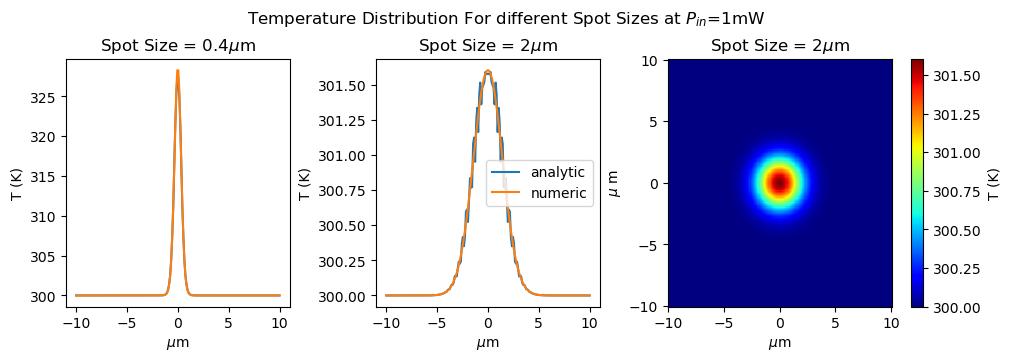

In [119]:
temp = RS.RamanSolver(nx=200,ny=200,lx=10e-6,ly=10e-6, h=0.7e-9, alpha=0.04, w0=0.4e-6,l0=0.4e-6)
f, (ax1,ax2, ax3)=plt.subplots(1,3,figsize=(10,3.5), constrained_layout=True)

# the default parameters for calculating the steady-state temperature distribution are the taube best fit pars
T_num = temp.Txy()
T_an = temp.analytic_Txy()
ax1.plot(temp.x*1e6,T_an[0,:,100])
ax1.plot(temp.x*1e6,T_num[0,:,100])

temp.update_w0(2e-6)
temp.update_l0(2e-6)
T_num = temp.Txy()
T_an = temp.analytic_Txy()
ax2.plot(temp.x*1e6,T_an[0,:,100],label='analytic')
ax2.plot(temp.x*1e6,T_num[0,:,100],label='numeric')
ax2.legend()

im = ax3.pcolormesh(temp.X[0]*1e6, temp.Y[0]*1e6, T_num[0], cmap='jet')
f.colorbar(im, label='T (K)')

ax1.set_xlabel(r'$\mu$m')
ax2.set_xlabel(r'$\mu$m')
ax3.set_xlabel(r'$\mu$m')
ax1.set_ylabel(r'T (K)')
ax2.set_ylabel(r'T (K)')
ax3.set_ylabel(r'$\mu$ m')

ax1.set_title(r'Spot Size = 0.4$\mu$m')
ax2.set_title(r'Spot Size = 2$\mu$m')
ax3.set_title(r'Spot Size = 2$\mu$m')
f.suptitle(r'Temperature Distribution For different Spot Sizes at $P_{in}$=1mW');

The oscillitory nature of the temperature distribution in the analytic solution comes from the oscillatory nature of the bessel functions in the solution. However since for fitting we are calculating the weighted average of the temperature distribution, these features become not significant. 

##### 2. Plot and model experimental data
Here, we simulate experimental data by calculating dT/dQ as a function of power, ``RamanSolver.dTdQ_sim``, for two different spot sizes, 0.4 $\mu m$ abd 1 $\mu m$. To dynamically change the spot size, we use ``RamanSolver.update_w0`` and ``RamanSolver.update_l0``. 
We add some gaussian noise to the simulation to make it look more like "experimental" data 

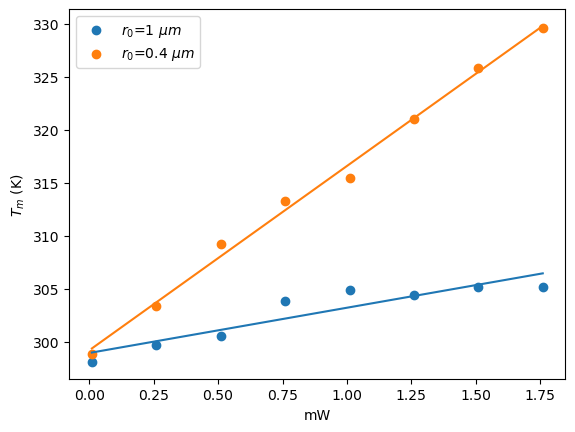

In [5]:
r1 = 1e-6
temp.update_w0(r1)
temp.update_l0(r1)
exp_data_r1 = temp.dTdQ_sim(kx,ky,g,Q)
# adding some noise to make it more "experimental"
exp_data_r1 += np.random.normal(size=exp_data_r1.shape)
popt, pcov = curve_fit(linear, Q, exp_data_r1)
exp_slope_r1 = popt[0]
plt.scatter(Q*1e3,exp_data_r1, label=r'$r_0$=1 $\mu m$')
plt.plot(Q*1e3, linear(Q, *popt))

r2 = 0.4e-6
temp.update_w0(r2)
temp.update_l0(r2)
exp_data_r2 = temp.dTdQ_sim(kx,ky,g,Q)
# adding some noise to make it more "experimental"
exp_data_r2 += np.random.normal(size=exp_data_r2.shape)
popt, pcov = curve_fit(linear, Q, exp_data_r2)
exp_slope_r2 = popt[0]
plt.scatter(Q*1e3,exp_data_r2, label=r'$r_0$=0.4 $\mu m$')
plt.plot(Q*1e3, linear(Q, *popt))

plt.xlabel('mW')
plt.ylabel(r'$T_m$ (K)')
plt.legend()

##### 3. Solve for k/g ratio using analytic solver
The analytic solver allows for the unique solving of k/g ratio for two experimental slopes, $\frac{dT}{dQ} |_{r=r_1}$, $\frac{dT}{dQ} |_{r=r_2}$. The ratio is found using ``RamanSolver.get_ratio`` and the thermal properties are found using ``RamanSolver.get_props_analytic`` with the found ratio. Two thermal conductivities and thermal boundary conductances are returned (and their average). The two values come from using the ratio to solve for k and g from each experimental slope. 

In [108]:
temp.get_ratio(exp_slope_r1, exp_slope_r2,r1, r2, 2e6/60, bounds=((0.,np.inf),),tol=1e-7)
ratio = temp.found_ratio
k1, g1, k2, g2, k_av, g_av = temp.get_props_analytic(60, ratio, 1e-6, 0.4e-6, exp_slope_r1, exp_slope_r2, Q, verbose=True)

0.04013788211127581
0.04013788211127842
0.04013788211120958
0.040137882111212
solving k1
[1212.09858114]
[1212.09862674]
[795.25474256]
[795.25466706]
[107.87757531]
[107.87751005]
[2.59285764]
[2.59279394]
[0.00157426]
[0.0015106]
[2.00088834e-11]
[6.36536952e-05]
solving k2
[1078.98604971]
[1078.98629299]
[76.35651528]
[76.35625479]
[0.33201768]
[0.33175832]
[6.85382838e-06]
[0.0002525]
[1.40897355e-05]


Plotting the best fit k, g with the experimental data.

Text(0.5, 0, 'P$_{in}$ (W)')

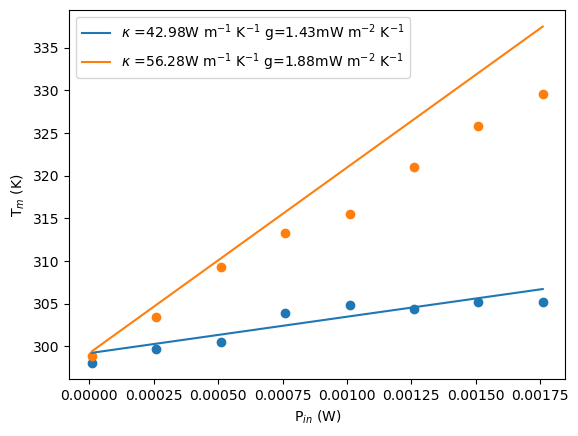

In [121]:
temp.update_w0(r1)
temp.update_l0(r1)
plt.scatter(Q, exp_data_r1)
plt.plot(Q, linear(Q, temp.dTdQ(k1, k1, g1,Q),popt[-1]), label=fr"$\kappa$ =" + str(round(k1,2)) + r"W m$^{-1}$ K$^{-1}$ g=" + str(round(g1/1e6,2)) + r"mW m$^{-2}$ K$^{-1}$")


temp.update_w0(r2)
temp.update_l0(r2)
plt.scatter(Q, exp_data_r2)
plt.plot(Q, linear(Q, temp.dTdQ(k2, k2, g1,Q),popt[-1]), label=fr"$\kappa$ =" + str(round(k2,2)) + r"W m$^{-1}$ K$^{-1}$ g=" + str(round(g2/1e6,2)) + r"mW m$^{-2}$ K$^{-1}$")

plt.legend()
plt.ylabel(r'T$_m$ (K)')
plt.xlabel(r'P$_{in}$ (W)')

##### 4. Solve for k,g  using numeric solver
k and g can also be solved in a few ways using the numeric solver. The first is to simultaneously fit the slopes (2 or n slopes), using ``RamanSolver.get_k_g``. This method seems to overestimate the thermal conductivity, due to the higher contribution of g to the slope. 

We re-initialize RamanSolver with multiple spot sizes. (This can also be done dynamically with ``RamanSolver.update_w0, RamanSolver.update_l0``)

In [123]:
temp = RS.RamanSolver(nx=200,ny=200,lx=10e-6,ly=10e-6, h=0.7e-9, alpha=0.04, w0=np.array([1E-6,0.4E-6]),l0=np.array([1E-6,0.4E-6]))

In [125]:
root = temp.get_k_g([50,2E6], np.array([exp_slope_r1, exp_slope_r2]), Q, 
             bounds=((0.01,0.1E6),(100,30E6)))

50.0 2000000.0 0.0018230967245994503
50.00000074505806 2000000.0 0.0018230967609890454
50.0 2000000.0298023224 0.0018230969840550624
56.814269470186055 1849838.8745727492 0.001147117403486866
56.81427031678464 1849838.8745727492 0.0011471173633620696
56.814269470186055 1849838.9021374965 0.001147117230815138
92.07138391362717 1635468.8485958083 0.0009249005573912982
92.0713852855977 1635468.8485958083 0.0009249005003130683
92.07138391362717 1635468.8729661931 0.0009249004049848009
96.09800664714153 1628439.725964064 0.0008031563964468537
96.09800807911341 1628439.725964064 0.0008031563383754228
96.09800664714153 1628439.7502297068 0.0008031562468486177
99.82868853737531 1609809.1383523243 0.0007676599749860361
99.8286900249387 1609809.1383523243 0.0007676599154822784
99.82868853737531 1609809.1623403498 0.0007676598273485383
99.9999999999969 1608873.5356347742 0.0007665673755884836
99.99999850988078 1608873.5356347742 0.0007665674351613625
99.9999999999969 1608873.559608858 0.000766567

Text(0.5, 0, 'P$_{in}$ (W)')

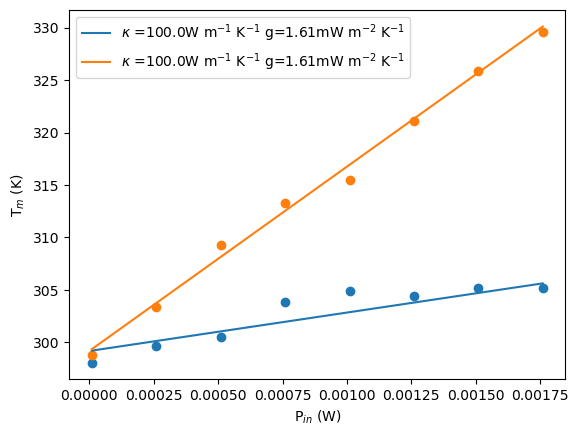

In [128]:
plt.scatter(Q, exp_data_r1)
plt.scatter(Q, exp_data_r2)
dtdq_r1, dtdq_r2 = temp.dTdQ(root.x[0],root.x[0],root.x[1],Q)
plt.plot(Q, linear(Q,dtdq_r1,popt[-1]), label=fr"$\kappa$ =" + str(round(root.x[0],2)) + r"W m$^{-1}$ K$^{-1}$ g=" + str(round(root.x[1]/1e6,2)) + r"mW m$^{-2}$ K$^{-1}$")
plt.plot(Q, linear(Q,dtdq_r2,popt[-1]), label=fr"$\kappa$ =" + str(round(root.x[0],2)) + r"W m$^{-1}$ K$^{-1}$ g=" + str(round(root.x[1]/1e6,2)) + r"mW m$^{-2}$ K$^{-1}$")
plt.legend()
plt.ylabel(r'T$_m$ (K)')
plt.xlabel(r'P$_{in}$ (W)')

##### 4a. Solve for g  using numeric solver
In some cases with supported samples, ramn thermometry is most sensitive to the out-of-plane thermal boundary conductance, so we can fit the equation solving for only one unkonwn -- g. This requires k to be fixed -- either 0 or a known value. This solving can be implemented with ``RamanSolver.get_g_fixk``. In this first example we fix k to 0 and solve for g using the two different dT/dQ from experiments

Text(0.5, 0, 'P$_{in}$ (W)')

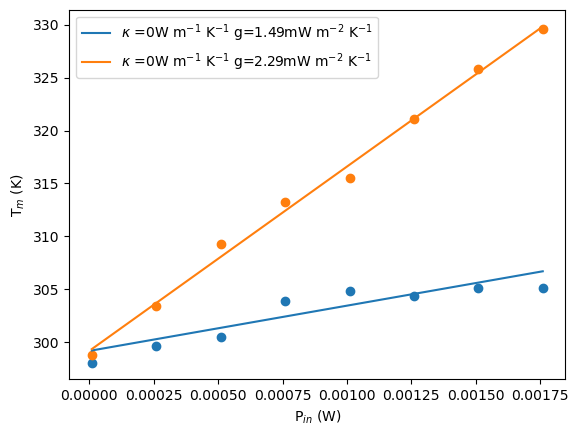

In [130]:
temp = RS.RamanSolver(nx=200,ny=200,lx=10e-6,ly=10e-6, h=0.7e-9, alpha=0.04, w0=r1,l0=r1)
root = temp.get_g_fixk(2E6, exp_slope_r1, Q, bounds=((0.1E6,),(30E6,)), kx=0, ky=0)


plt.scatter(Q, exp_data_r1)
dtdq_r1 = temp.dTdQ(0,0,root.x[0], Q)
plt.plot(Q, linear(Q,dtdq_r1,popt[-1]), label=fr"$\kappa$ =" + str(round(0,2)) + r"W m$^{-1}$ K$^{-1}$ g=" + str(round(root.x[0]/1e6,2)) + r"mW m$^{-2}$ K$^{-1}$")

temp.update_l0(r2)
temp.update_w0(r2)
root = temp.get_g_fixk(2E6, exp_slope_r2, Q, bounds=((0.1E6,),(30E6,)), kx=0, ky=0)
dtdq_r2 = temp.dTdQ(0,0,root.x[0], Q)
plt.scatter(Q, exp_data_r2)
plt.plot(Q, linear(Q,dtdq_r2,popt[-1]), label=fr"$\kappa$ =" + str(round(0,2)) + r"W m$^{-1}$ K$^{-1}$ g=" + str(round(root.x[0]/1e6,2)) + r"mW m$^{-2}$ K$^{-1}$")
plt.legend()
plt.ylabel(r'T$_m$ (K)')
plt.xlabel(r'P$_{in}$ (W)')

##### 4b. Solve for g  using numeric solver
Similarly, some people extract dT/dQ for greater than two spot sizes, to fit to the full dT/dQ vs. r curve. Here, we simulate this data and run the fitting process. We initialize ``RamanSolver`` with an array of spot sizes, visualize the temperature distribution and dT/dQ vs. r, and fit the data. 

In [131]:
r_array = r_from_zl(0.4e-6, np.arange(0.E-6,2E-6, 0.2E-6), 0.9)
temp = RS.RamanSolver(nx=200,ny=200,lx=10e-6,ly=10e-6, h=0.7e-9, alpha=0.04, w0=r_array,l0=r_array)
kx= 62.2
ky = 62.2
g = 1.94E6
T = temp.Txy(kx=kx, ky=ky, g=g)
dTdQ_sim = temp.dTdQ(kx=kx, ky=ky, g=g, Q=Q)

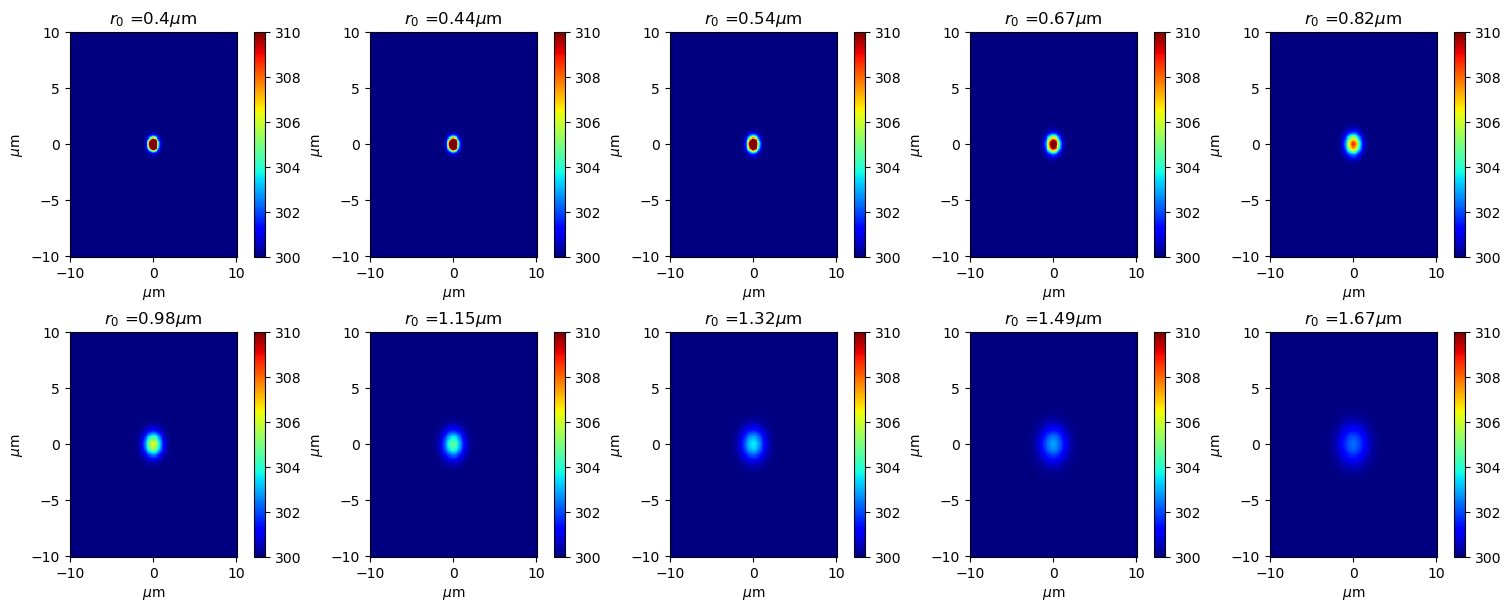

In [132]:
f, axs = plt.subplots(2,5,figsize=(15,6), constrained_layout=True)
axs = axs.ravel()
for ax, r, Ti in zip(axs, r_array, T): 
    ax.set_title(r'$r_0$ =' + str(round(r*1e6, 2)) + r'$\mu$m')
    im = ax.pcolormesh(temp.X[0]*1e6, temp.Y[0]*1e6, Ti, cmap='jet', vmin=300, vmax=310)
    f.colorbar(im)
    ax.set_xlabel(r'$\mu$m')
    ax.set_ylabel(r'$\mu$m')

Text(0.5, 0, 'P$_{in}$ (W)')

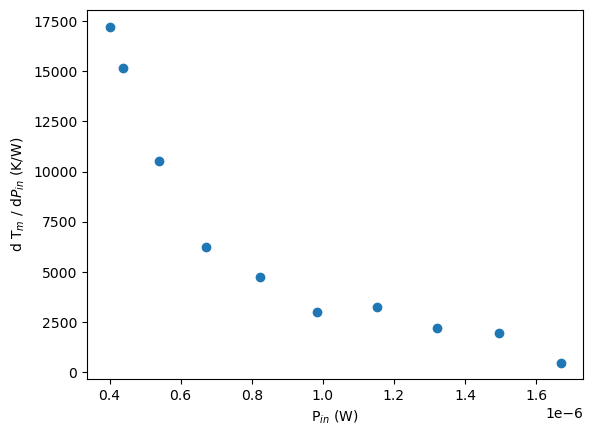

In [133]:
dTdQ_exp = dTdQ_sim + 1e3*np.random.normal(size=dTdQ_sim.shape)
plt.scatter(r_array, dTdQ_exp)
plt.ylabel(r'd T$_m$ / d$P_{in}$ (K/W)')
plt.xlabel(r'P$_{in}$ (W)')

In [136]:
root= temp.get_k_g([10,5E6], dTdQ_exp, Q, bounds=((0.01,0.1E6),(100,30E6)))
dTdQ_fit = temp.dTdQ(kx=root.x[0], ky=root.x[0], g=root.x[1], Q=Q)

10.0 5000000.0 0.037391142309946654
10.000000149011612 5000000.0 0.03739114231429248
10.0 5000000.074505806 0.03739114271385023
4.405087477263748 2212580.376140978 0.005108546181268367
4.405087542904666 2212580.376140978 0.005108546181265279
4.405087477263748 2212580.409110995 0.005108546357346056
15.2379230027244 2108125.1972384164 0.004721775480344685
15.237923229787148 2108125.1972384164 0.004721775479930765
15.2379230027244 2108125.2286519296 0.004721775573523487
39.57082294277059 1955884.8514257208 0.004233463206116942
39.5708235324218 1955884.8514257208 0.004233463206862598
39.57082294277059 1955884.8805706762 0.004233463305416874
47.91181358004984 1919847.8782113115 0.0041224411765065395
47.9118142939915 1919847.8782113115 0.004122441177909046
47.91181358004984 1919847.9068192742 0.004122441276802238
52.15956551901141 1898605.8361214043 0.004056342701811555
52.1595662962495 1898605.8361214043 0.004056342703584389
52.15956551901141 1898605.864412836 0.004056342802720935
52.754225

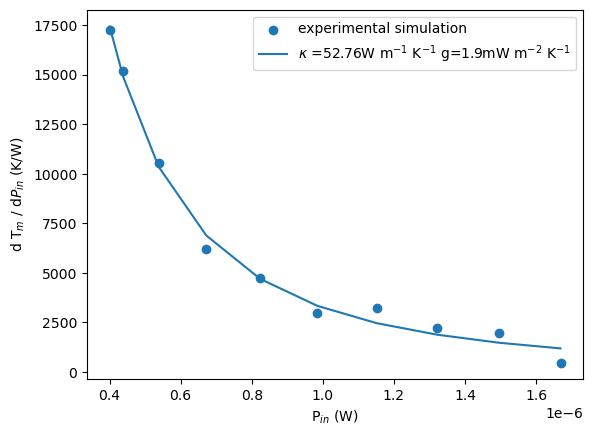

In [138]:
plt.scatter(r_array, dTdQ_exp, label='experimental simulation')
plt.plot(r_array, dTdQ_fit, label=fr"$\kappa$ =" + str(round(root.x[0],2)) + r"W m$^{-1}$ K$^{-1}$ g=" + str(round(root.x[1]/1e6,2)) + r"mW m$^{-2}$ K$^{-1}$")
plt.ylabel(r'd T$_m$ / d$P_{in}$ (K/W)')
plt.xlabel(r'P$_{in}$ (W)')
plt.legend()

Having more equations gives a better fit of the thermal conductivity and thermal boundary conductance. We can similarly fit the data with k fixed. Here fixing it to 62.2 $W m^{-1} K^{-1}$

In [139]:
root_fixk = temp.get_g_fixk([5E6],dTdQ_exp, Q, 62.2,62.2,bounds=((0.1E6,),(30E6,)))
dTdQ_fit_fixk = temp.dTdQ(kx=62.2, ky=62.2, g=root_fixk.x[0], Q=Q)

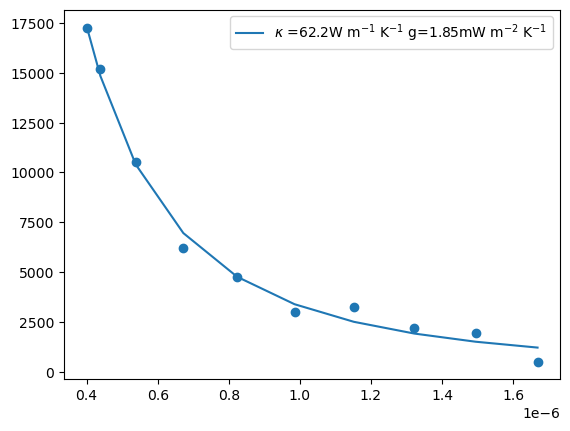

In [140]:
plt.scatter(r_array, dTdQ_exp)
plt.plot(r_array, dTdQ_fit_fixk, label=fr"$\kappa$ =" + str(round(62.2,2)) + r"W m$^{-1}$ K$^{-1}$ g=" + str(round(root_fixk.x[0]/1e6,2)) + r"mW m$^{-2}$ K$^{-1}$")
plt.legend()

Here we show the different ways to fit isotropic laser heating in the optothermal raman technique to a material with isotropic in-plane thermal conductivity. Depending on the experimental capabilities, different fitting procedures may be needed. 